In [ ]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import networkx as nx
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 12
mpl.rcParams['font.family'] = 'Arial'
os.makedirs("../figures", exist_ok=True)
figpath = '../figures/figure1'
os.makedirs(figpath, exist_ok=True)
adata = sc.read_h5ad("../data/adata-preF.h5ad")
adata

AnnData object with n_obs × n_vars = 178891 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellphoneDB', 'batch_colors', 'dendrogram_leiden', 'epi-subtype_colors', 'gender_colors', 'hvg', 'leiden', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'majorType-fix_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 'minor_type_colors', 'molecular_type_colors', 'neigh

In [22]:
adata.obs['IHC'] = list(adata.obs['molecular_type'])
adata.obs.loc[adata.obs['IHC'] == 'HER2', 'IHC'] = 'HR-HER2+'
adata.obs.loc[adata.obs['IHC'] == 'LumB-HER2', 'IHC'] = 'HR+HER2+'
adata.obs.loc[adata.obs['IHC'] == 'Luminal B', 'IHC'] = 'HR+HER2-'

In [ ]:
#find the best params
def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

def propPlot(age_df, ax, colors=sc.pl.palettes.default_20, xlabel='Patient ID', show_y=True, xrotate=90, title=''):
    all_df = age_df.sum(axis=1)
    age_normdf = pd.DataFrame([age_df.loc[i,:]/all_df[i] for i in barlabels], index=barlabels)
    age_cumdf = pd.DataFrame([np.cumsum(age_normdf.loc[i,:]) for i in barlabels], index=barlabels)
    norm_gdfs = age_normdf
    cum_gdfs = age_cumdf
    for i, col in enumerate(age_df.columns):
        height = norm_gdfs[col]
        starts = cum_gdfs[col] - height
        rects = ax.bar(barlabels, height, bottom=starts, width=0.9, edgecolor='white', linewidth=0.5,
                        label=col, alpha=1)
    
        # ax.bar_label(rects,age_df.loc[:, col], label_type='center', color='lightgrey', fontsize=14)
    ax.legend( bbox_to_anchor=(1, 0),
              title=title, 
              handletextpad=0.5, frameon=False,
                          borderpad=0.6,
                          columnspacing=1.3,
                          handlelength=0.65,
              loc='lower left', fontsize=14)
    if show_y:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        ax.set_ylabel('Cell proportions')
    else:
        ax.yaxis.set_visible(False)
        ax.spines.left.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_xticks(barlabels)
    ax.set_xticklabels(labels=barlabels,rotation=xrotate,fontsize=13)

Ignoring processing doublet cells...
Evaluating neighbors only...


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


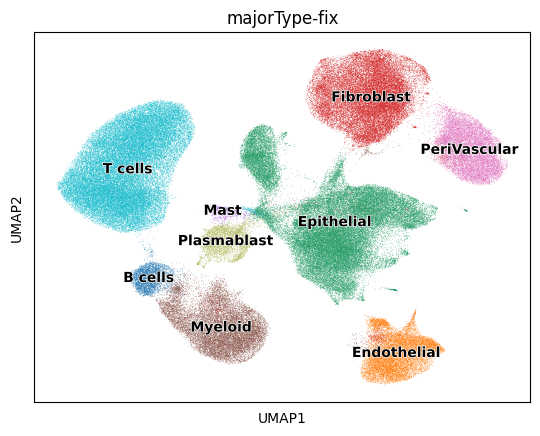

In [ ]:
# n_neighbors=50, n_pcs=14
adata = clu(adata, n_neighbors=50, n_pcs=14)

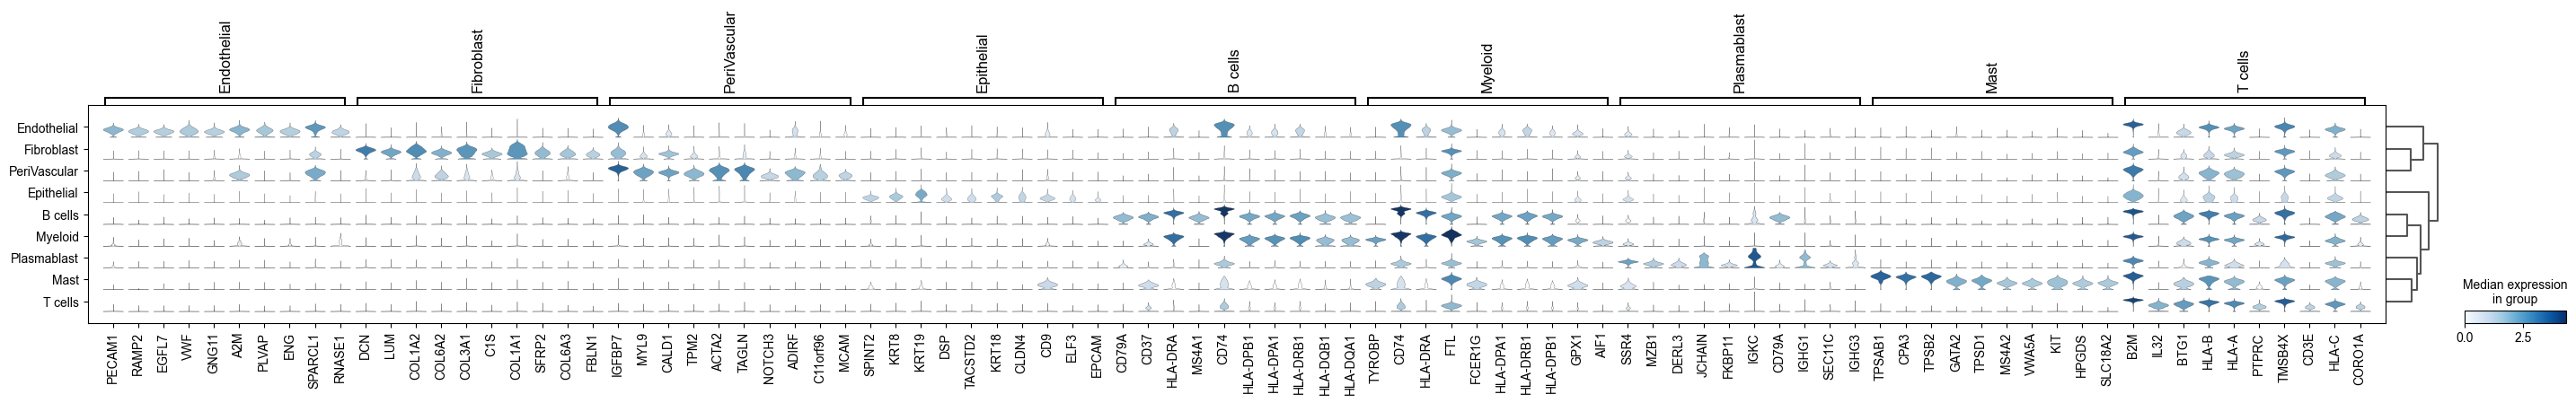

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='majorType-fix',method='wilcoxon')
sc.tl.dendrogram(adata, groupby='majorType-fix')
sc.pl.rank_genes_groups_stacked_violin(adata, groupby='majorType-fix', n_genes=5)

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


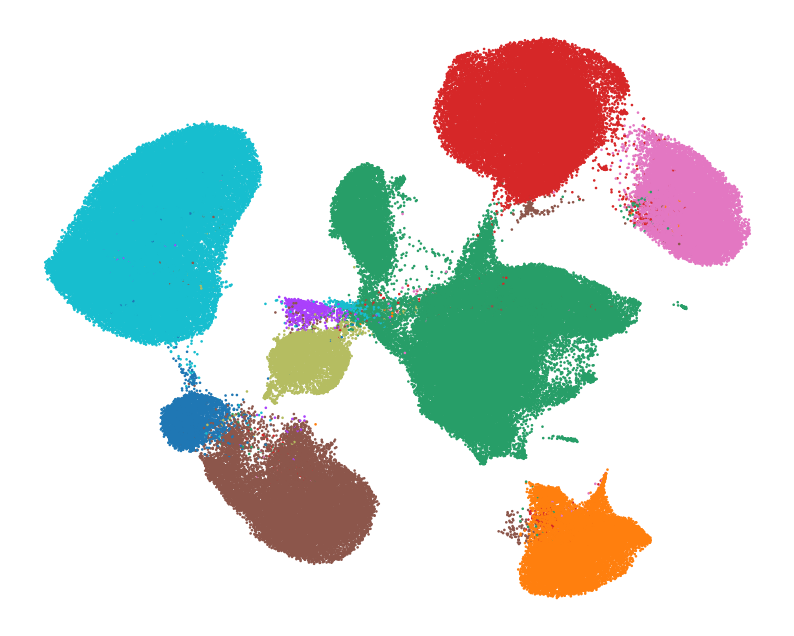

In [ ]:
# Fig.1b: Save the Major UMAP
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sc.pl.umap(adata, color='majorType-fix',size=14, ax=ax, title='',show=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend().set_visible(False)
fig.savefig("../figures/figure1/1b.png", dpi=400)

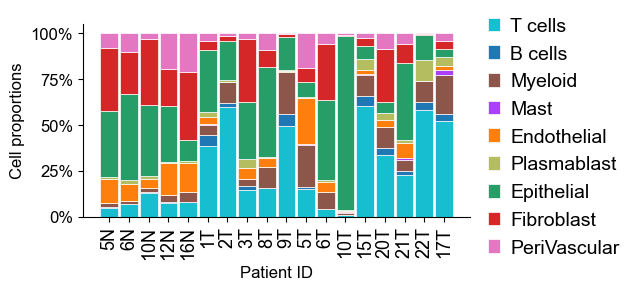

In [ ]:
# Fig.1d: Save the cell proportions
barlabels = ['5N', '6N', '10N', '12N','16N','1T', '2T', '3T', '8T', '9T', '5T','6T', '10T','15T','20T', '21T', '22T','17T']
cell_types = ['T cells', 'B cells', 'Myeloid', 'Mast', 'Endothelial','Plasmablast', 'Epithelial', 'Fibroblast', 
       'PeriVascular']
colors = pd.Series(sc.pl.palettes.default_20[:9], index=adata.obs['majorType-fix'].cat.categories)
colors = colors[cell_types]
age_df = pd.DataFrame(columns = list(cell_types))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata[(adata.obs["majorType-fix"] == ct) & (adata.obs["batch"] == bar)]) for ct in list(cell_types)], index = list(cell_types), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
fig0, ax0 = plt.subplots(figsize=(5, 2.5))
propPlot(age_df, barlabels, ax0, colors=colors)
fig0.savefig(f"../figures/figure1/1d-proportions.svg",bbox_inches='tight')

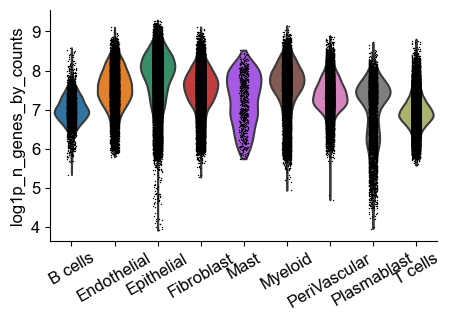

In [ ]:
# Fig.s1a-d: Save the lop1p_n_genes_by_counts
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sc.pl.violin(adata, keys=['log1p_n_genes_by_counts'], groupby='majorType-fix', ax=ax, title='',show=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("")
ax.set_xticklabels(adata.obs['majorType-fix'].cat.categories, rotation=30)
fig.savefig(f"../figures/figure1/s1b-count.svg", dpi=400, bbox_inches='tight')

Ignoring processing doublet cells...
Evaluating neighbors only...


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


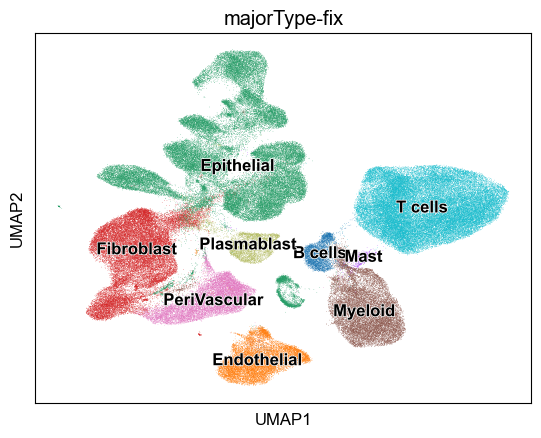

In [ ]:
# Fig.s1e: Run finding_neighbors and UMAP without batch correction
adata = clu(adata, n_neighbors=50, n_pcs=14, rep='X_pca')

In [ ]:
# Fig.s1e-f: batch and IHC subtype for supplementary information
for gene in ['batch', 'IHC']:
  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  sc.pl.umap(adata, color=gene,size=4, ax=ax, title='',show=False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.set_xlabel("")
  ax.set_ylabel("")
  fig.savefig(f"../figures/figure1/s1e-{gene}.png", dpi=400, bbox_inches='tight')

In [ ]:
# save the adata-preF without harmony
# adata.write_h5ad("adata-preF-pcs14-nohar.h5ad")

In [ ]:
# adata-preF.h5ad has been created
# adata.write_h5ad("adata-preF.h5ad")

... storing 'batch' as categorical
... storing 'molecular_type' as categorical


In [26]:
adata_epi_cnv = adata[adata.obs['majorType-fix'].isin(['B cells', 'T cells', 'Endothelial', 'Epithelial']) , :]
adata_epi_cnv

View of AnnData object with n_obs × n_vars = 115192 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix', 'IHC'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellphoneDB', 'batch_colors', 'dendrogram_leiden', 'epi-subtype_colors', 'gender_colors', 'hvg', 'leiden', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'majorType-fix_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 'minor_type_colors', 'neighbors', 'pc

In [27]:
# concat gene position for CNV analysis 
chrom = pd.read_csv("../data/gene_pos.txt", sep='\t', header=None)
chrom.columns = ["symbol", "ensg", "chromosome", "start", "end"]
chrom.index = chrom['symbol']
chrom['ensg'] = [name.split('.')[0] for name in chrom['ensg']]
chrom_ensg = chrom.copy()
chrom_ensg.index = chrom_ensg['ensg']
var_names = list(adata_epi_cnv.var_names[adata_epi_cnv.var_names.isin(chrom['symbol']) + adata_epi_cnv.var_names.isin(chrom['ensg'])])
adata_epi_var = adata_epi_cnv[:, var_names]
for i in range(len(var_names)):
    name = var_names[i]
    if name in chrom_ensg['ensg']:
        var_names[i] = chrom_ensg['symbol'][name]
adata_epi_var.var_names = var_names
chrom_var_names = chrom.loc[var_names, :]
adata_epi_cnv = adata_epi_cnv[:, adata_epi_cnv.var_names.isin(chrom['symbol']) + adata_epi_cnv.var_names.isin(chrom['ensg'])]
adata_epi_cnv.var_names = var_names
adata_epi_cnv.var = pd.concat([adata_epi_var.var, chrom_var_names], axis=1)
adata_epi_cnv.var_names_make_unique()
adata_epi_cnv

AnnData object with n_obs × n_vars = 115192 × 39735
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix', 'IHC'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'CellphoneDB', 'batch_colors', 'dendrogram_leiden', 'epi-subtype_colors', 'gender_colors', 'hvg', 'leiden', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'majorType-fix_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors

  0%|          | 0/24 [00:00<?, ?it/s]

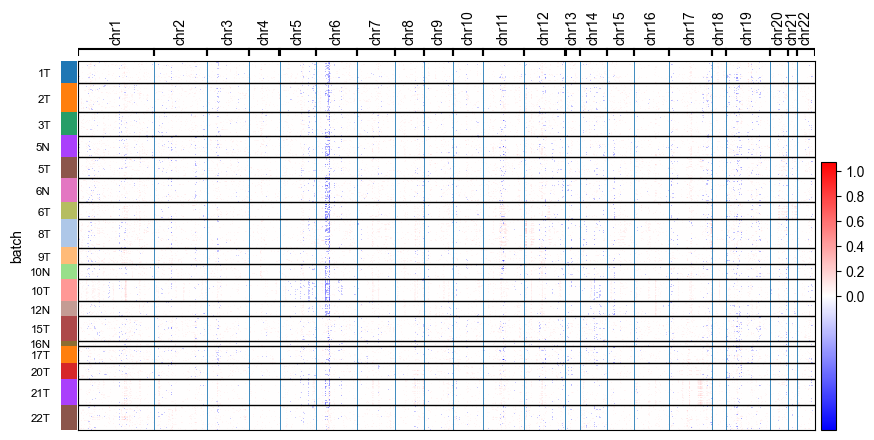

In [28]:
import infercnvpy as cnv 
cnv.tl.infercnv(adata_epi_cnv,reference_key="majorType-fix", reference_cat=['B cells', 'T cells', 'Endothelial'])
cnv.pl.chromosome_heatmap(adata_epi_cnv, groupby='batch', figsize=(10, 5))

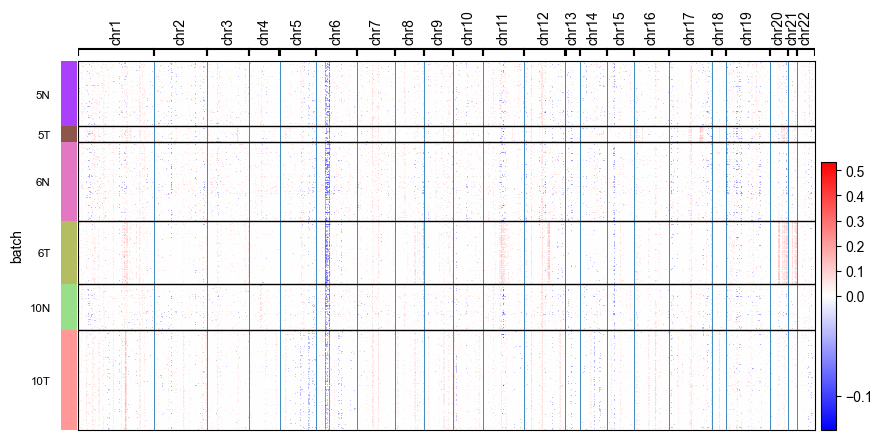

In [29]:
adata_epi_cnv = adata_epi_cnv[adata_epi_cnv.obs['majorType-fix']=='Epithelial']
adata_epi_vs = adata_epi_cnv[adata_epi_cnv.obs['batch'].isin(['5N', '5T', '6N', '6T', '10N', '10T'])]
cnv.pl.chromosome_heatmap(adata_epi_vs, groupby='batch', figsize=(10, 5), save='s1m-vsheatmap.svg')

In [ ]:
adata_epi_tumor = adata_epi_cnv[adata_epi_cnv.obs['molecular_type'] != 'Normal']

/home/rzh/BCY/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/rzh/BCY/lib/python3.10/site-packages/infercnvpy/tl/__init__.py:73: ImplicitModificationWarning: Setting element `.obsm['X_cnv_pca']` of view, initializing view as actual.
  adata.obsm[f"X_{key_added}"] = pca_res
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


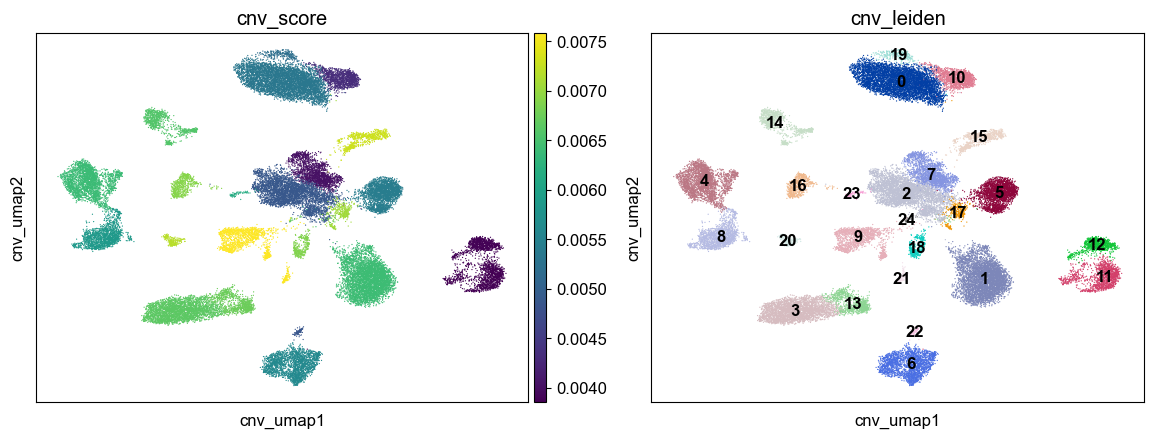

In [172]:
cnv.tl.pca(adata_epi_tumor) 
cnv.pp.neighbors(adata_epi_tumor) 
cnv.tl.leiden(adata_epi_tumor)
cnv.tl.umap(adata_epi_tumor) 
cnv.tl.cnv_score(adata_epi_tumor)
cnv.pl.umap(adata_epi_tumor, color=['cnv_score', 'cnv_leiden'], legend_loc='on data')

In [ ]:
adata_epi_cnv.obs['cnv_status'] = 'Neoplastic'
adata_epi_cnv.obs['cnv_status'].loc[adata_epi_cnv.obs['cnv_leiden'].isin(['2', '7', '10', '11', '12'])] = 'Normal'

/tmp/ipykernel_2237227/3157399586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_epi_cnv.obs['cnv_status'].loc[adata_epi_cnv.obs['cnv_leiden'].isin(['2', '3', '4', '22', '24', '11', '13', '15'])] = 'Normal'


/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


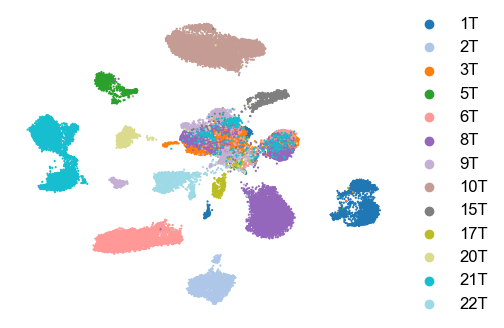

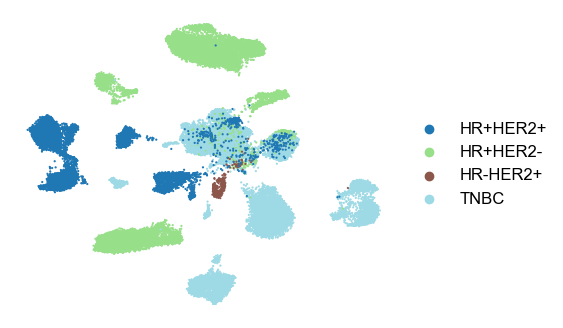

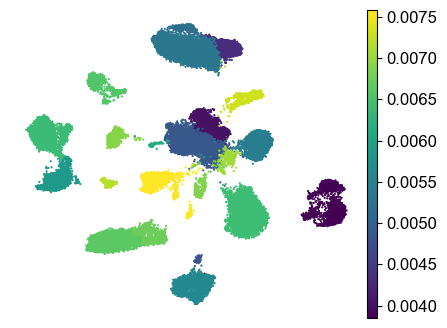

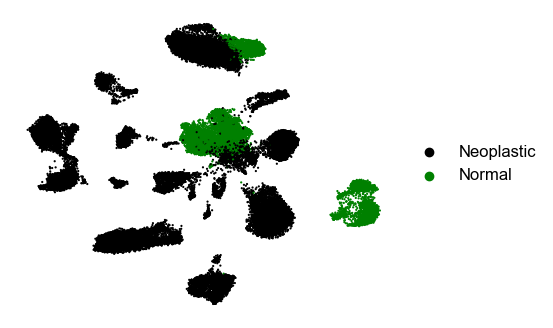

In [ ]:
for gene in ['batch', 'IHC', 'cnv_score', 'cnv_status']:
  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  cnv.pl.umap(adata_epi_tumor, color=gene,size=10, ax=ax, title='',show=False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.set_xlabel("")
  ax.set_ylabel("")
  # ax.legend(  handletextpad=0.5, frameon=False,
  #                     borderpad=0.6,
  #                     columnspacing=1.3,
  #                     handlelength=0.65, fontsize=12)
  fig.savefig(f"../figures/figure1/2d-{gene}.png", dpi=400, bbox_inches='tight')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2237227/994677382.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommoda

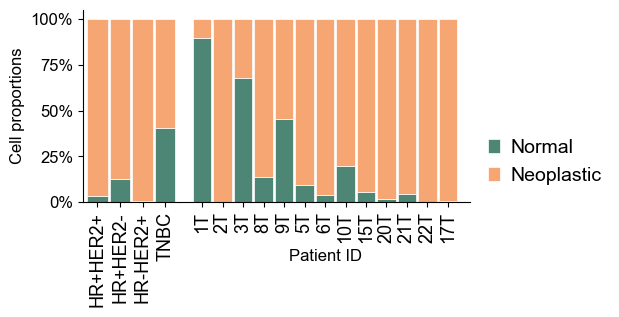

In [ ]:
# print immune epi and mesenchyme cell proportions
import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout=True, figsize=(5,2.5))
gs = gridspec.GridSpec(1, 4, wspace=0)


barlabels = ['HR+HER2+', 'HR+HER2-', 'HR-HER2+', 'TNBC']
general_types = {
    'Normal': ['Normal'],
    'Neoplastic':['Neoplastic'],
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata_epi_tumor[(adata_epi_tumor.obs["cnv_status"].isin(general_types[type])) & (adata_epi_tumor.obs["IHC"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
ax1 = fig.add_subplot(gs[0, :1])
propPlot(age_df, barlabels, ax1,colors=['#4d8675', '#f5a673'], xlabel='')

barlabels = ['1T', '2T', '3T',  '8T', '9T', '5T','6T', '10T', '15T', '20T', '21T', '22T','17T']
general_types = {
    'Normal': ['Normal'],
    'Neoplastic': ['Neoplastic'],
}
age_df = pd.DataFrame(columns = list(general_types.keys()))
for bar in barlabels:
    d1 = pd.DataFrame([len(adata_epi_tumor[(adata_epi_tumor.obs["cnv_status"].isin(general_types[type])) & (adata_epi_tumor.obs["batch"] == bar)]) 
                       for type in list(general_types.keys())], 
                      index =list(general_types.keys()), columns=[bar]).T
    age_df = pd.concat([age_df, d1])
ax2 = fig.add_subplot(gs[0, 1:])
propPlot(age_df, barlabels, ax2,colors=['#4d8675', '#f5a673'], show_y=False)
fig.savefig(f"../figures/figure1/1j-proportions.svg",bbox_inches='tight')

In [ ]:
# saving CNV analysis data (it has been created)
# adata_epi_cnv.write_h5ad("../data/adata-Fepi1.h5ad")

In [ ]:
adata_Fepi = sc.read_h5ad(f"{datapath}/adata-epi-cnv.h5ad")

In [26]:
sc.tl.rank_genes_groups(adata_Fepi,
                        groupby='cnv_status',
                        use_raw=False,
                        method='wilcoxon',
                        groups=["Tumor"],
                        reference='Normal')

In [139]:
sc.tl.score_genes(adata_Fepi, score_name='LumB-Her2-score',gene_list=['TRIM37', 'SKA2', 'YPEL2', 'MIEN1', 'PTRH2', 'CLTC', 'BST2',"ERBB2", 'IFI6', 'GRB7', 'S100A14', 'LRRC59', 'COMT', 'TOM1L1', 'SLC25A1', "ISG15",'APPBP2','TAGLN2', 'USP32'])
sc.tl.score_genes(adata_Fepi, score_name='Her2-score',gene_list=['PSMB3', 'IFI27', 'S100A9', 'CISD3',"LASP1", 'MRPL45', 'PSMD3', 'TPI1', 'PFN1', 'TPT1', 'URI1', 'TUBB', "CDKN2A",'EGLN3','TMSB10', 'TMSB4X'])
sc.tl.score_genes(adata_Fepi, score_name='LumB-score',gene_list=['COX6C', 'PARD6B', 'CA12', 'TPM3',"H2AJ", 'PRSS23', 'SLC7A2', 'EEF1A2', 'ESR1', 'KCNE4', 'FLNB', 'IGFBP4', "RAB31",'HSPB1','FOXA1', 'GATA3','ADARB1', 'POFUT2'])
sc.tl.score_genes(adata_Fepi, score_name='TNBC-score',gene_list=['PERP', 'GSTP1', 'YBX3', 'YBX1',"CALD1", 'IGKC', 'UBE2C'])

In [307]:
from supervenn import supervenn

In [308]:
gene_2021_her2 = ['PSMA2', 'PPP1R1B', 'SYNGR2', 'CNPY2', 'LGALS7B', 'CYBA', 'FTH1', 'MSL1', 'IGKV3.15', 'STARD3', 'HPD', 'HMGCS2', 'ID3', 'NDUFB8', 'COTL1', 'AIM1', 'MED24', 'CEACAM6', 'FABP7', 'CRABP2', 'NR4A2', 'COX14', 'ACADM', 'PKM', 'ECH1', 'C17orf89', 'NGRN', 'ATG5', 'SNHG25', 'ETFB', 'EGLN3', 'CSNK2B', 'RHOC', 'PSENEN', 'CDK12', 'ATP5I', 'ENTHD2', 'QRSL1', 'S100A7', 'TPM1', 'ATP5C1', 'HIST1H1E', 'LGALS1', 'GRB7', 'AQP3', 'ALDH2', 'EIF3E', 'ERBB2', 'LCN2', 'SLC38A10', 'TXN', 'DBI', 'RP11.206M11.7', 'TUBB', 'CRYAB', 'CD9', 'PDSS2', 'XIST', 'MED1', 'C6orf203', 'PSMD3', 'TMC5', 'UQCRQ', 'EFHD1', 'BCAM', 'GPX1', 'EPHX1', 'AREG', 'CDK2AP2', 'SPINK8', 'PGAP3', 'NFIC', 'THRSP', 'LDHB', 'MT1X', 'HIST1H4C', 'LRRC26', 'SLC16A3', 'BACE2', 'MIEN1', 'AR', 'CRIP2', 'NME1', 'DEGS2', 'CASC3', 'FOLR1', 'SIVA1', 'SLC25A39', 'IGHG1', 'ORMDL3', 'KRT81', 'SCGB2B2', 'LINC01285', 'CXCL8', 'KRT15', 'RSU1', 'ZFP36L2', 'DKK1', 'TMED10', 'IRX3', 'S100A9', 'YWHAZ']
gene_2021_lumb = ['UGCG', 'ARMT1', 'ISOC1', 'GDF15', 'ZFP36', 'PSMC5', 'DDX5', 'TMEM150C', 'NBEAL1', 'CLEC3A', 'GADD45G', 'MARCKS', 'FHL2', 'CCDC117', 'LY6E', 'GJA1', 'PSAP', 'TAF7', 'PIP', 'HSPA2', 'DSCAM.AS1', 'PSMB7', 'STARD10', 'ATF3', 'WBP11', 'MALAT1', 'C6orf48', 'HLA.DRB1', 'HIST1H2BD', 'CCND1', 'STC2', 'NR4A1', 'NPY1R', 'FOS', 'ZFAND2A', 'CFL1', 'RHOB', 'LMNA', 'SLC40A1', 'CYB5A', 'SRSF5', 'SEC61G', 'CTSD', 'DNAJC12', 'IFITM1', 'MAGED2', 'RBP1', 'TFF1', 'APLP2', 'TFF3', 'TRH', 'NUPR1', 'EMC3', 'TXNIP', 'ARPC4', 'KCNE4', 'ANPEP', 'MGST1', 'TOB1', 'ADIRF', 'TUBA1B', 'MYEOV2', 'MLLT4', 'DHRS2', 'IFITM2']
gene_2021_tnbc = ["EMP1", "TAGLN", "TTYH1", "RTN4", "TK1", "BUB3", "IGLV3-25", "FAM3C", "TMEM123", "KDM5B", "KRT14", "ALG3", "KLK6", "EEF2", "NSMCE4A", "LYST", "DEDD", "HLA-DRA", "PAPOLA", "SOX4", "ACTR3B", "EIF3D", "CACYBP", "RARRES1", "STRA13", "MFGE8", "FRZB", "SDHD", "UCHL1", "TMEM176A", "CAV2", "MARCO", "P4HB", "CHI3L2", "APOE", "ATP1B1", "C6orf15", "KRT6B", "TAF1D", "ACTA2", "LY6D", "SAA2", "CYP27A1", "DLK1", "IGKV1-5", "CENPW", "RAB18", "TNFRSF11B", "VPS28", "HULC", "KRT16", "CDKN2A", "AHNAK2", "SEC22B", "CDC42EP1", "HMGA1", "CAV1", "BAMBI", "TOMM22", "ATP6V0E2", "MTCH2", "PRSS21", "HDAC2", "ZG16B", "GAL", "SCGB1D2", "S100A2", "GSPT1", "ARPC1B", "NIT1", "NEAT1", "DSC2","MAL2", "TMEM176B", "CYP1B1", "EIF3L", "FKBP4", "WFDC2", "SAA1", "CXCL17", "PFDN2", "UCP2", "RAB11B", "FDCSP", "HLA.DPB1", "PCSK1N", "C4orf48", "CTSC"]
gene_2021 = set(gene_2021_her2+gene_2021_lumb+gene_2021_tnbc).intersection(adata.var_names)
len(gene_2021)

237

In [ ]:
LumBHer2_list = ['TRIM37', 'SKA2', 'YPEL2', 'MIEN1', 'PTRH2', 'CLTC', 'BST2', 'IFI6', 'GRB7', 'S100A14', 'LRRC59', 'COMT', 'TOM1L1', 'SLC25A1', "ISG15",'APPBP2','TAGLN2', 'USP32']
Her2_list = ['PSMB3', 'IFI27', 'S100A9', 'CISD3',"LASP1", 'MRPL45', 'PSMD3', 'TPI1', 'PFN1', 'TPT1', 'URI1', 'TUBB', "CDKN2A",'EGLN3','TMSB10', 'TMSB4X','ERBB2']
LumB_list = ['COX6C', 'PARD6B', 'CA12', 'TPM3',"H2AJ", 'PRSS23', 'SLC7A2', 'EEF1A2', 'ESR1', 'KCNE4', 'FLNB', 'IGFBP4', "RAB31",'HSPB1','FOXA1', 'GATA3','ADARB1', 'POFUT2']
TNBC_list = ['PERP', 'GSTP1', 'YBX3', 'YBX1',"CALD1", 'IGKC', 'B2M', 'PTMA']
Normal_list = ['ZFP36', 'APP', 'SFRP1', 'EGR1', 'PNRC1', 'PER1', 'EEF2', "SRSF5", 'CXCL2']
bcy_genes = LumBHer2_list+Her2_list+LumB_list+TNBC_list+Normal_list
wu_genes = gene_2021
pam50_genes = ["ACTR3B", "ANLN", "BAG1", "BCL2", "BIRC5", "BLVRA", "CCNB1", "CCNE1", "CDC20", "CDC6", "CDCA1", "CDH3", "CENPF", "CEP55", "CXXC5", "EGFR", "ERBB2", "ESR1", "EXO1", "FGFR4", "FOXA1", "FOXC1", "GPR160", "GRB7", "KIF2C", "KNTC2", "KRT14", "KRT17", "KRT5", "MAPT", "MDM2", "MELK", "MIA", "MKI67", "MLPH", "MMP11", "MYBL2", "MYC", "NAT1", "ORC6L", "PGR", "PHGDH", "PTTG1", "RRM2", "SFRP1", "SLC39A6", "TMEM45B", "TYMS", "UBE2C", "UBE2T"]

In [429]:
# read pseudobulk data
agg_Fepi = sc.read_csv("Fepi-agg.tsv", delimiter='\t')
agg_Fepi.obs['PAM50'] = ['TNBC','TNBC','TNBC','Normal','Luminal B','Normal','Luminal B','TNBC','TNBC','Luminal B','Normal','Normal','Luminal B','Luminal A','HER2','Luminal B','Luminal B','TNBC']
agg_Fepi.obs['molecular_type'] = ['TNBC', 'TNBC','TNBC','Normal','Luminal B','Normal','Luminal B','TNBC','TNBC','Luminal B','Normal','Normal','Luminal B','Normal','HER2','LumB-HER2','LumB-HER2','LumB-HER2']

In [430]:
sc.tl.score_genes(agg_Fepi, score_name='LumB-Her2-score',gene_list=LumBHer2_list)
sc.tl.score_genes(agg_Fepi, score_name='Her2-score',gene_list=Her2_list)
sc.tl.score_genes(agg_Fepi, score_name='LumB-score',gene_list=LumB_list)
sc.tl.score_genes(agg_Fepi, score_name='TNBC-score',gene_list=TNBC_list)
sc.tl.score_genes(agg_Fepi, score_name='Normal-score',gene_list=Normal_list)

In [431]:
subtypes = ['LumB-HER2', 'HER2', 'Luminal B', 'TNBC', 'Normal']
arg = np.argmax(np.array(agg_Fepi.obs[['LumB-Her2-score', 'Her2-score', 'LumB-score', 'TNBC-score', 'Normal-score']]), axis=1)
agg_Fepi.obs['BCYType'] = [subtypes[s] for s in arg]
agg_Fepi.obs

,PAM50,molecular_type,LumB-Her2-score,Her2-score,LumB-score,TNBC-score,Normal-score,BCYType
1T,TNBC,TNBC,49.104877,966.317297,163.657136,3384.568420,1221.079790,TNBC
2T,TNBC,TNBC,149.273961,1390.198656,7.956480,1838.784566,96.553093,TNBC
3T,TNBC,TNBC,173.576830,1237.791616,125.037544,3516.807082,2648.044996,TNBC
5N,Normal,Normal,-57.964374,889.147587,320.587758,2020.784817,5273.597226,Normal
5T,Luminal B,Luminal B,342.863679,444.347620,663.461255,291.764293,406.912205,Luminal B
6N,Normal,Normal,-61.410110,751.972601,380.398199,2373.325483,5692.420695,Normal
6T,Luminal B,Luminal B,166.463442,1605.178645,3017.879819,226.043874,961.951890,Luminal B
8T,TNBC,TNBC,43.713939,1266.527276,-219.701176,5397.051441,4017.121745,TNBC
9T,TNBC,TNBC,142.167969,495.702067,150.375101,725.589195,467.436988,TNBC
10T,Luminal B,Luminal B,-242.426992,1373.693437,8270.313544,-49.994078,1775.543520,Luminal B


In [432]:
# pseudobulk level 
gene_2021_her2 = ['PSMA2', 'PPP1R1B', 'SYNGR2', 'CNPY2', 'LGALS7B', 'CYBA', 'FTH1', 'MSL1', 'IGKV3.15', 'STARD3', 'HPD', 'HMGCS2', 'ID3', 'NDUFB8', 'COTL1', 'AIM1', 'MED24', 'CEACAM6', 'FABP7', 'CRABP2', 'NR4A2', 'COX14', 'ACADM', 'PKM', 'ECH1', 'C17orf89', 'NGRN', 'ATG5', 'SNHG25', 'ETFB', 'EGLN3', 'CSNK2B', 'RHOC', 'PSENEN', 'CDK12', 'ATP5I', 'ENTHD2', 'QRSL1', 'S100A7', 'TPM1', 'ATP5C1', 'HIST1H1E', 'LGALS1', 'GRB7', 'AQP3', 'ALDH2', 'EIF3E', 'ERBB2', 'LCN2', 'SLC38A10', 'TXN', 'DBI', 'RP11.206M11.7', 'TUBB', 'CRYAB', 'CD9', 'PDSS2', 'XIST', 'MED1', 'C6orf203', 'PSMD3', 'TMC5', 'UQCRQ', 'EFHD1', 'BCAM', 'GPX1', 'EPHX1', 'AREG', 'CDK2AP2', 'SPINK8', 'PGAP3', 'NFIC', 'THRSP', 'LDHB', 'MT1X', 'HIST1H4C', 'LRRC26', 'SLC16A3', 'BACE2', 'MIEN1', 'AR', 'CRIP2', 'NME1', 'DEGS2', 'CASC3', 'FOLR1', 'SIVA1', 'SLC25A39', 'IGHG1', 'ORMDL3', 'KRT81', 'SCGB2B2', 'LINC01285', 'CXCL8', 'KRT15', 'RSU1', 'ZFP36L2', 'DKK1', 'TMED10', 'IRX3', 'S100A9', 'YWHAZ']
gene_2021_lumb = ['UGCG', 'ARMT1', 'ISOC1', 'GDF15', 'ZFP36', 'PSMC5', 'DDX5', 'TMEM150C', 'NBEAL1', 'CLEC3A', 'GADD45G', 'MARCKS', 'FHL2', 'CCDC117', 'LY6E', 'GJA1', 'PSAP', 'TAF7', 'PIP', 'HSPA2', 'DSCAM.AS1', 'PSMB7', 'STARD10', 'ATF3', 'WBP11', 'MALAT1', 'C6orf48', 'HLA.DRB1', 'HIST1H2BD', 'CCND1', 'STC2', 'NR4A1', 'NPY1R', 'FOS', 'ZFAND2A', 'CFL1', 'RHOB', 'LMNA', 'SLC40A1', 'CYB5A', 'SRSF5', 'SEC61G', 'CTSD', 'DNAJC12', 'IFITM1', 'MAGED2', 'RBP1', 'TFF1', 'APLP2', 'TFF3', 'TRH', 'NUPR1', 'EMC3', 'TXNIP', 'ARPC4', 'KCNE4', 'ANPEP', 'MGST1', 'TOB1', 'ADIRF', 'TUBA1B', 'MYEOV2', 'MLLT4', 'DHRS2', 'IFITM2']
gene_2021_tnbc = ["EMP1", "TAGLN", "TTYH1", "RTN4", "TK1", "BUB3", "IGLV3-25", "FAM3C", "TMEM123", "KDM5B", "KRT14", "ALG3", "KLK6", "EEF2", "NSMCE4A", "LYST", "DEDD", "HLA-DRA", "PAPOLA", "SOX4", "ACTR3B", "EIF3D", "CACYBP", "RARRES1", "STRA13", "MFGE8", "FRZB", "SDHD", "UCHL1", "TMEM176A", "CAV2", "MARCO", "P4HB", "CHI3L2", "APOE", "ATP1B1", "C6orf15", "KRT6B", "TAF1D", "ACTA2", "LY6D", "SAA2", "CYP27A1", "DLK1", "IGKV1-5", "CENPW", "RAB18", "TNFRSF11B", "VPS28", "HULC", "KRT16", "CDKN2A", "AHNAK2", "SEC22B", "CDC42EP1", "HMGA1", "CAV1", "BAMBI", "TOMM22", "ATP6V0E2", "MTCH2", "PRSS21", "HDAC2", "ZG16B", "GAL", "SCGB1D2", "S100A2", "GSPT1", "ARPC1B", "NIT1", "NEAT1", "DSC2","MAL2", "TMEM176B", "CYP1B1", "EIF3L", "FKBP4", "WFDC2", "SAA1", "CXCL17", "PFDN2", "UCP2", "RAB11B", "FDCSP", "HLA.DPB1", "PCSK1N", "C4orf48", "CTSC"]
gene_2021_luma = ['SH3BGRL', 'HSPB1', 'PHGR1', 'SOX9', 'CEBPD', 'CITED2', 'TM4SF1', 'S100P', 'KCNK6', 'AGR3', 'MPC2', 'CXCL13', 'RNASET2', 'DDIT4', 'SCUBE2', 'KRT8', 'MZT2B', 'IFI6', 'RPS26', 'TAGLN2', 'SPTSSA', 'ZFP36L1', 'MGP', 'KDELR2', 'PPDPF', 'AZGP1', 'AP000769.1', 'MYBPC1', 'S100A1', 'TFPI2', 'JUN', 'SLC25A6', 'HSP90AB1', 'ARF5', 'PMAIP1', 'TNFRSF12A', 'FXYD3', 'RASD1', 'PYCARD', 'PYDC1', 'PHLDA2', 'BZW2', 'HOXA9', 'XBP1', 'AGR2', 'HSP90AA1']
sc.tl.score_genes(agg_Fepi, score_name='wu_Her2-score',gene_list=gene_2021_her2)
sc.tl.score_genes(agg_Fepi, score_name='wu_LumB-score',gene_list=gene_2021_lumb)
sc.tl.score_genes(agg_Fepi, score_name='wu_TNBC-score',gene_list=gene_2021_tnbc)
# sc.tl.score_genes(agg_Fepi, score_name='wu_LumA-score',gene_list=gene_2021_luma)
subtypes = ['HER2', 'Luminal B', 'TNBC']
arg = np.argmax(np.array(agg_Fepi.obs[['wu_Her2-score', 'wu_LumB-score', 'wu_TNBC-score']]), axis=1)
agg_Fepi.obs['ScSubtype'] = [subtypes[s] for s in arg]
agg_Fepi.obs[['molecular_type','BCYType', 'PAM50', 'ScSubtype']]

,molecular_type,BCYType,PAM50,ScSubtype
1T,TNBC,TNBC,TNBC,Luminal B
2T,TNBC,TNBC,TNBC,TNBC
3T,TNBC,TNBC,TNBC,Luminal B
5N,Normal,Normal,Normal,Luminal B
5T,Luminal B,Luminal B,Luminal B,Luminal B
6N,Normal,Normal,Normal,Luminal B
6T,Luminal B,Luminal B,Luminal B,Luminal B
8T,TNBC,TNBC,TNBC,Luminal B
9T,TNBC,TNBC,TNBC,Luminal B
10T,Luminal B,Luminal B,Luminal B,Luminal B


In [433]:
from sklearn.metrics import adjusted_rand_score, accuracy_score, normalized_mutual_info_score
perf = pd.DataFrame(index=['BCYType', 'PAM50', 'ScSubtype'])
for index in [accuracy_score, adjusted_rand_score, normalized_mutual_info_score]:
  score = [index(agg_Fepi.obs['molecular_type'], agg_Fepi.obs[meth]) for meth in ['BCYType', 'PAM50', 'ScSubtype']]
  perf[index.__name__] = score
perf

,accuracy_score,adjusted_rand_score,normalized_mutual_info_score
BCYType,0.888889,0.744716,0.844027
PAM50,0.777778,0.630011,0.790020
ScSubtype,0.333333,0.061350,0.302234


In [415]:
# single-cell level PAM50
scPAM50 = pd.read_csv('single-cell_PAM50.tsv', sep='\t',index_col=0)
adata_Fepi.obs['PAM50'] = scPAM50
adata_Fepi.obs.loc[adata_Fepi.obs['PAM50'] == 'Basal', 'PAM50'] = 'TNBC'
adata_Fepi.obs.loc[adata_Fepi.obs['PAM50'] == 'LumB', 'PAM50'] = 'Luminal B'
adata_Fepi.obs.loc[adata_Fepi.obs['PAM50'] == 'Her2', 'PAM50'] = 'HER2'
adata_Fepi.obs.loc[adata_Fepi.obs['PAM50'] == 'LumA', 'PAM50'] = 'Luminal A'

In [414]:
adata_Fepi.obs['PAM50'].unique()

array(['Normal', 'LumA', 'Basal', 'Her2', 'LumB'], dtype=object)

In [407]:
# single-cell level BCYtype
sc.tl.score_genes(adata_Fepi, score_name='LumB-Her2-score',gene_list=LumBHer2_list)
sc.tl.score_genes(adata_Fepi, score_name='Her2-score',gene_list=Her2_list)
sc.tl.score_genes(adata_Fepi, score_name='LumB-score',gene_list=LumB_list)
sc.tl.score_genes(adata_Fepi, score_name='TNBC-score',gene_list=TNBC_list)
sc.tl.score_genes(adata_Fepi, score_name='Normal-score',gene_list=Normal_list)
subtypes = ['LumB-HER2', 'HER2', 'Luminal B', 'TNBC', 'Normal']
arg = np.argmax(np.array(adata_Fepi.obs[['LumB-Her2-score', 'Her2-score', 'LumB-score', 'TNBC-score', 'Normal-score']]), axis=1)
adata_Fepi.obs['BCYType'] = [subtypes[s] for s in arg]
adata_Fepi.obs

,batch,mt_frac,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_genes,n_counts,leiden,major_type,...,LumB-old-score,Her2-old-score,epi-type,cptype,sample,score,proli_score,PAM50,Normal-score,BCYType
barcodes,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGACCAAGC-1-1T,1T,0.101613,3418,8.137103,14073.0,9.552084,3417,14072.0,23,Epithelial,...,0.267100,0.280205,Basal Normal,Basal Normal,1T,-0.022601,-0.022601,Normal,0.496125,TNBC
AAACCCATCACTTTGT-1-1T,1T,0.129870,2526,7.834788,8008.0,8.988321,2526,8008.0,23,Epithelial,...,0.308034,0.209303,Basal Normal,Basal Normal,1T,-0.047560,-0.047560,Normal,0.690271,TNBC
AAACGAAAGCGGATCA-1-1T,1T,0.132144,1916,7.558517,8521.0,9.050406,1916,8521.0,23,PeriVascular,...,0.146849,0.161523,LumHR Normal,LumHR Normal,1T,-0.052226,-0.052226,LumA,0.164934,TNBC
AAACGAACACAGTGTT-1-1T,1T,0.104349,1791,7.491088,5242.0,8.564650,1791,5242.0,23,Epithelial,...,0.348794,0.246670,Basal Normal,Basal Normal,1T,-0.009362,-0.009362,Normal,0.604282,TNBC
AAACGCTCAAGCAATA-1-1T,1T,0.098455,4888,8.494743,36504.0,10.505204,4886,36501.0,23,PeriVascular,...,0.125596,0.279764,Basal Normal,Basal Normal,1T,-0.046617,-0.046617,LumA,0.084192,TNBC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTCCCTACT-1-22T,22T,0.069257,5332,8.581669,27405.0,10.218517,5331,27404.0,19,Epithelial,...,0.094311,0.321104,LumSec Cancer,LumSec Cancer,22T,0.040859,0.040859,Basal,0.037749,TNBC
TTTGGTTGTGATGATA-1-22T,22T,0.037259,6027,8.704171,23323.0,10.057239,6027,23323.0,19,Epithelial,...,0.098697,0.270352,LumSec Cancer,LumSec Cancer,22T,-0.043768,-0.043768,Normal,0.451835,HER2
TTTGTCAAGGCAAAGA-1-22T,22T,0.025878,696,6.546785,1082.0,6.987490,696,1082.0,19,Epithelial,...,0.058063,0.177003,LumSec Cancer,LumSec Cancer,22T,0.019683,0.019683,Normal,0.169180,TNBC


In [417]:
# single-cell level SCSubtype
gene_2021_her2 = ['PSMA2', 'PPP1R1B', 'SYNGR2', 'CNPY2', 'LGALS7B', 'CYBA', 'FTH1', 'MSL1', 'IGKV3-15', 'STARD3', 'HPD', 'HMGCS2', 'ID3', 'NDUFB8', 'COTL1', 'AIM1', 'MED24', 'CEACAM6', 'FABP7', 'CRABP2', 'NR4A2', 'COX14', 'ACADM', 'PKM', 'ECH1', 'C17ORF89', 'NGRN', 'ATG5', 'SNHG25', 'ETFB', 'EGLN3', 'CSNK2B', 'RHOC', 'PSENEN', 'CDK12', 'ATP5I', 'ENTHD2', 'QRSL1', 'S100A7', 'TPM1', 'ATP5C1', 'HIST1H1E', 'LGALS1', 'GRB7', 'AQP3', 'ALDH2', 'EIF3E', 'ERBB2', 'LCN2', 'SLC38A10', 'TXN', 'DBI', 'RP11.206M11.7', 'TUBB', 'CRYAB', 'CD9', 'PDSS2', 'XIST', 'MED1', 'C6orf203', 'PSMD3', 'TMC5', 'UQCRQ', 'EFHD1', 'BCAM', 'GPX1', 'EPHX1', 'AREG', 'CDK2AP2', 'SPINK8', 'PGAP3', 'NFIC', 'THRSP', 'LDHB', 'MT1X', 'HIST1H4C', 'LRRC26', 'SLC16A3', 'BACE2', 'MIEN1', 'AR', 'CRIP2', 'NME1', 'DEGS2', 'CASC3', 'FOLR1', 'SIVA1', 'SLC25A39', 'IGHG1', 'ORMDL3', 'KRT81', 'SCGB2B2', 'LINC01285', 'CXCL8', 'KRT15', 'RSU1', 'ZFP36L2', 'DKK1', 'TMED10', 'IRX3', 'S100A9', 'YWHAZ']
gene_2021_lumb = ['UGCG', 'ARMT1', 'ISOC1', 'GDF15', 'ZFP36', 'PSMC5', 'DDX5', 'TMEM150C', 'NBEAL1', 'CLEC3A', 'GADD45G', 'MARCKS', 'FHL2', 'CCDC117', 'LY6E', 'GJA1', 'PSAP', 'TAF7', 'PIP', 'HSPA2', 'DSCAM.AS1', 'PSMB7', 'STARD10', 'ATF3', 'WBP11', 'MALAT1', 'C6orf48', 'HLA.DRB1', 'HIST1H2BD', 'CCND1', 'STC2', 'NR4A1', 'NPY1R', 'FOS', 'ZFAND2A', 'CFL1', 'RHOB', 'LMNA', 'SLC40A1', 'CYB5A', 'SRSF5', 'SEC61G', 'CTSD', 'DNAJC12', 'IFITM1', 'MAGED2', 'RBP1', 'TFF1', 'APLP2', 'TFF3', 'TRH', 'NUPR1', 'EMC3', 'TXNIP', 'ARPC4', 'KCNE4', 'ANPEP', 'MGST1', 'TOB1', 'ADIRF', 'TUBA1B', 'MYEOV2', 'MLLT4', 'DHRS2', 'IFITM2']
gene_2021_tnbc = ["EMP1", "TAGLN", "TTYH1", "RTN4", "TK1", "BUB3", "IGLV3-25", "FAM3C", "TMEM123", "KDM5B", "KRT14", "ALG3", "KLK6", "EEF2", "NSMCE4A", "LYST", "DEDD", "HLA-DRA", "PAPOLA", "SOX4", "ACTR3B", "EIF3D", "CACYBP", "RARRES1", "STRA13", "MFGE8", "FRZB", "SDHD", "UCHL1", "TMEM176A", "CAV2", "MARCO", "P4HB", "CHI3L2", "APOE", "ATP1B1", "C6orf15", "KRT6B", "TAF1D", "ACTA2", "LY6D", "SAA2", "CYP27A1", "DLK1", "IGKV1-5", "CENPW", "RAB18", "TNFRSF11B", "VPS28", "HULC", "KRT16", "CDKN2A", "AHNAK2", "SEC22B", "CDC42EP1", "HMGA1", "CAV1", "BAMBI", "TOMM22", "ATP6V0E2", "MTCH2", "PRSS21", "HDAC2", "ZG16B", "GAL", "SCGB1D2", "S100A2", "GSPT1", "ARPC1B", "NIT1", "NEAT1", "DSC2","MAL2", "TMEM176B", "CYP1B1", "EIF3L", "FKBP4", "WFDC2", "SAA1", "CXCL17", "PFDN2", "UCP2", "RAB11B", "FDCSP", "HLA.DPB1", "PCSK1N", "C4orf48", "CTSC"]
gene_2021_luma = ['SH3BGRL', 'HSPB1', 'PHGR1', 'SOX9', 'CEBPD', 'CITED2', 'TM4SF1', 'S100P', 'KCNK6', 'AGR3', 'MPC2', 'CXCL13', 'RNASET2', 'DDIT4', 'SCUBE2', 'KRT8', 'MZT2B', 'IFI6', 'RPS26', 'TAGLN2', 'SPTSSA', 'ZFP36L1', 'MGP', 'KDELR2', 'PPDPF', 'AZGP1', 'AP000769.1', 'MYBPC1', 'S100A1', 'TFPI2', 'JUN', 'SLC25A6', 'HSP90AB1', 'ARF5', 'PMAIP1', 'TNFRSF12A', 'FXYD3', 'RASD1', 'PYCARD', 'PYDC1', 'PHLDA2', 'BZW2', 'HOXA9', 'XBP1', 'AGR2', 'HSP90AA1']
sc.tl.score_genes(adata_Fepi, score_name='wu_Her2-score',gene_list=gene_2021_her2)
sc.tl.score_genes(adata_Fepi, score_name='wu_LumB-score',gene_list=gene_2021_lumb)
sc.tl.score_genes(adata_Fepi, score_name='wu_TNBC-score',gene_list=gene_2021_tnbc)
subtypes = ['HER2', 'Luminal B', 'TNBC']
arg = np.argmax(np.array(adata_Fepi.obs[['wu_Her2-score', 'wu_LumB-score', 'wu_TNBC-score']]), axis=1)
adata_Fepi.obs['ScSubtype'] = [subtypes[s] for s in arg]
adata_Fepi.obs[['molecular_type','BCYType', 'PAM50', 'ScSubtype']]

,molecular_type,BCYType,PAM50,ScSubtype
barcodes,,,,
AAACCCAAGACCAAGC-1-1T,TNBC,TNBC,Normal,Luminal B
AAACCCATCACTTTGT-1-1T,TNBC,TNBC,Normal,Luminal B
AAACGAAAGCGGATCA-1-1T,TNBC,TNBC,Luminal A,HER2
AAACGAACACAGTGTT-1-1T,TNBC,TNBC,Normal,Luminal B
AAACGCTCAAGCAATA-1-1T,TNBC,TNBC,Luminal A,HER2
...,...,...,...,...
TTTGGTTGTCCCTACT-1-22T,LumB-HER2,TNBC,TNBC,TNBC
TTTGGTTGTGATGATA-1-22T,LumB-HER2,HER2,Normal,TNBC
TTTGTCAAGGCAAAGA-1-22T,LumB-HER2,TNBC,Normal,TNBC


In [439]:
proli_list = ['BIRC5', 'CCNB1', 'CDC20', 'NUF2', 'CEP55', 'NDC80', 'MKI67', 'PTTG1', 'RRM2', 'TYMS', 'UBE2C']
sc.tl.score_genes(adata_Fepi, score_name='proli-score',gene_list=proli_list)

In [422]:
from sklearn.metrics import adjusted_rand_score, accuracy_score, normalized_mutual_info_score
perf = pd.DataFrame(index=['BCYType', 'PAM50', 'ScSubtype'])
for index in [accuracy_score, adjusted_rand_score, normalized_mutual_info_score]:
  score = [index(adata_Fepi.obs['molecular_type'], adata_Fepi.obs[meth]) for meth in ['BCYType', 'PAM50', 'ScSubtype']]
  perf[index.__name__] = score
perf

,accuracy_score,adjusted_rand_score,normalized_mutual_info_score
BCYType,0.824610,0.614573,0.585122
PAM50,0.256587,0.192796,0.218494
ScSubtype,0.301533,0.026778,0.074679


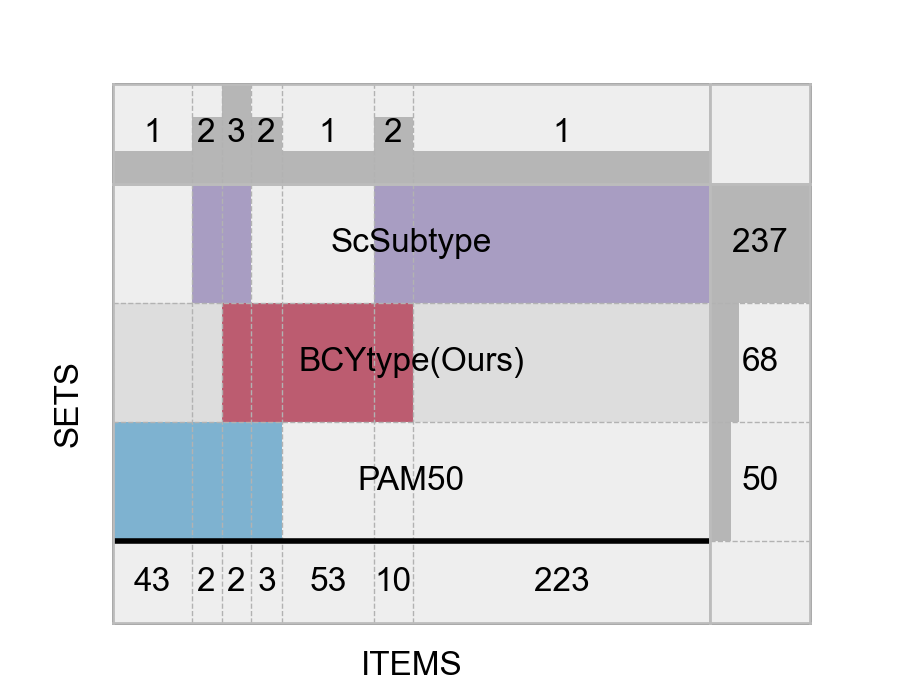

In [348]:
# draw venn
sets = [set(bcy_genes), set(wu_genes), set(pam50_genes)]
labels = ['BCYtype(Ours)', 'ScSubtype', 'PAM50']
fig, ax = plt.subplots(figsize=(4.5, 3.5))
with plt.style.context('bmh'):
  supervenn(sets, labels, widths_minmax_ratio=0.1, ax=ax,sets_ordering='minimize gaps', col_annotations_area_height=0.8,side_plot_width=0.5)
fig.savefig(f"{figpath}/supervenn.svg", bbox_inches='tight')

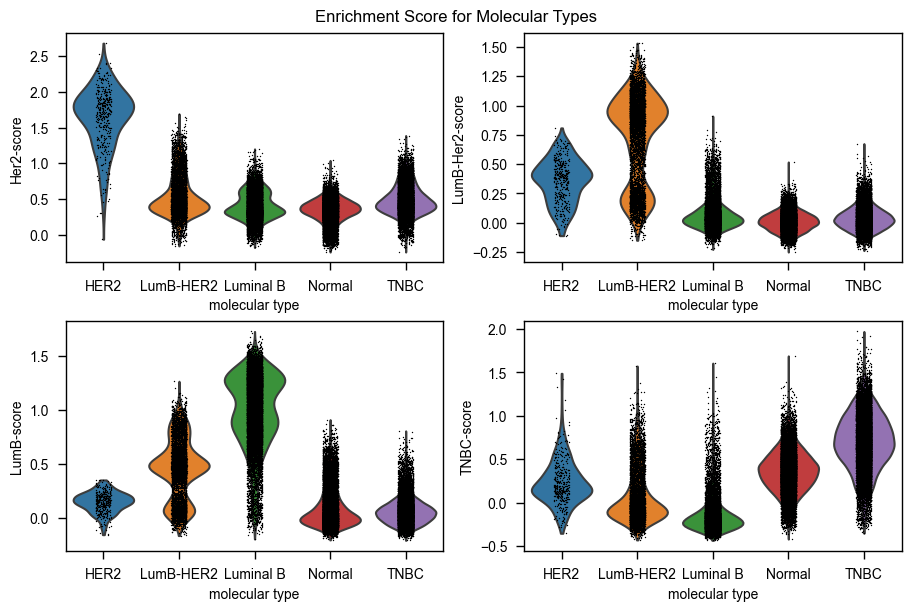

In [140]:
fig, ax = plt.subplots(2,2, figsize=(9,6), constrained_layout=True)
sc.pl.violin(adata_Fepi, groupby="molecular_type", keys='Her2-score',ax=ax[0][0], show=False)
sc.pl.violin(adata_Fepi, groupby="molecular_type", keys='LumB-Her2-score',ax=ax[0][1], show=False)
sc.pl.violin(adata_Fepi, groupby="molecular_type", keys='LumB-score',ax=ax[1][0], show=False)
sc.pl.violin(adata_Fepi, groupby="molecular_type", keys='TNBC-score',ax=ax[1][1], show=False)
fig.suptitle("Enrichment Score for Molecular Types")
fig.savefig(f"{folder}/score-mole.png", dpi=500)

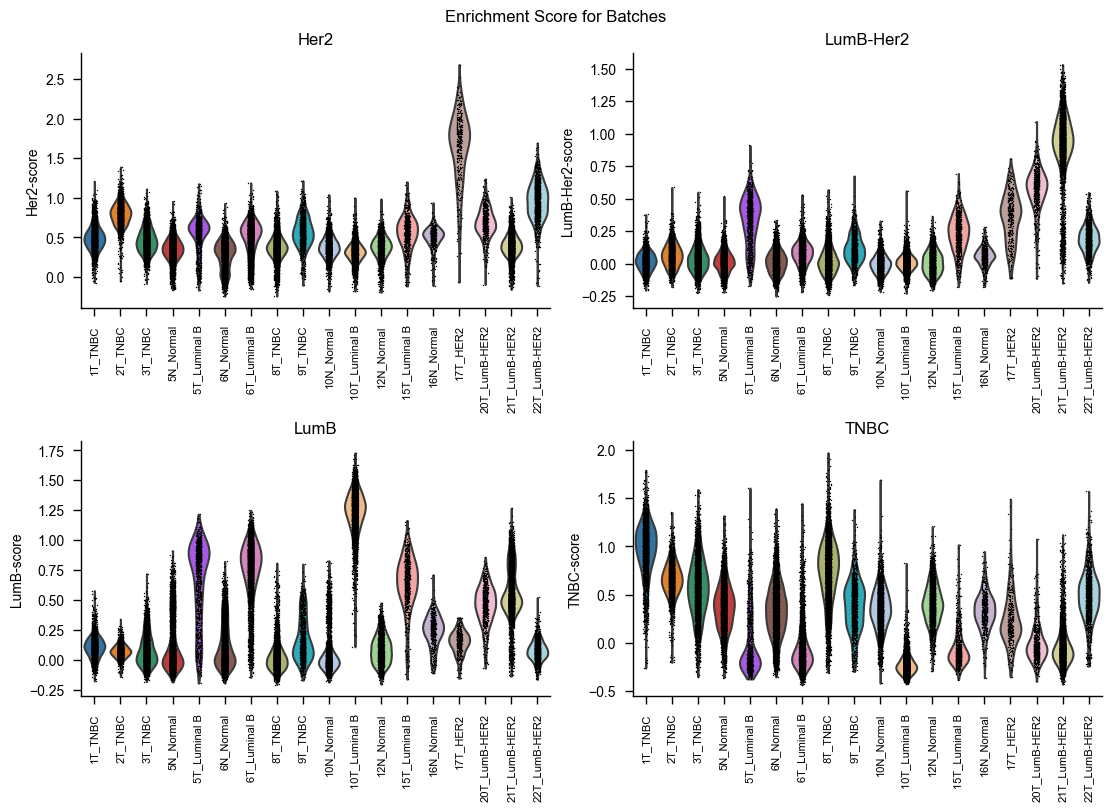

In [141]:
fig, ax = plt.subplots(2,2, figsize=(11,8), constrained_layout=True)
adata_Fepi.obs['batch_mol'] = [f"{x}_{y}" for x, y in zip(adata_Fepi.obs['batch'], adata_Fepi.obs['molecular_type'])]
by = 'batch_mol'
for i, x in enumerate(['Her2-score', 'LumB-Her2-score', 'LumB-score', 'TNBC-score']):
  sc.pl.violin(adata_Fepi, groupby=by, keys=x,ax=ax[int(i/2)][i%2], show=False)
  ax[int(i/2)][i%2].set_title(x.replace('-score', ''))
  ax[int(i/2)][i%2].spines.top.set_visible(False)
  ax[int(i/2)][i%2].spines.right.set_visible(False)
  xticks = ax[int(i/2)][i%2].get_xticklabels()
  ax[int(i/2)][i%2].set_xlabel('')
  ax[int(i/2)][i%2].set_xticklabels(xticks, rotation=90, fontsize=8)
fig.suptitle("Enrichment Score for Batches")
fig.savefig(f"{folder}/score-batch.png", dpi=500)

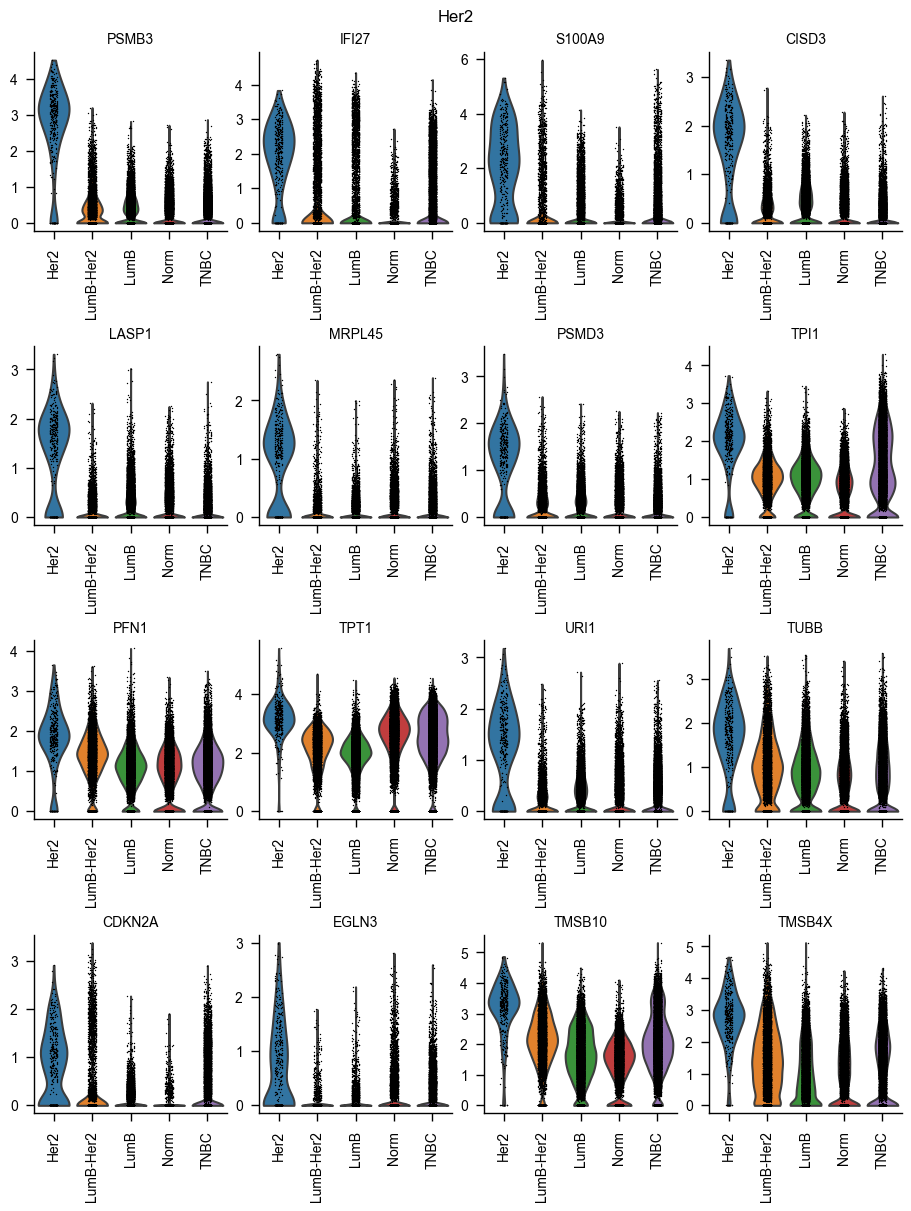

In [121]:
folder="figure-5.21"
markers = ['PSMB3', 'IFI27', 'S100A9', 'CISD3',"LASP1", 'MRPL45', 'PSMD3', 'TPI1', 'PFN1', 'TPT1', 'URI1', 'TUBB', "CDKN2A",'EGLN3','TMSB10', 'TMSB4X']
fig, ax = plt.subplots(4,4,figsize=(9,12), constrained_layout=True)
for i, m in enumerate(markers):
  col = 4
  sc.pl.violin(adata_Fepi, groupby='molecular_type',keys=m, ax=ax[int(i/col)][i%col], show=False)
  # ax[int(i/3)][i%3].legend_.remove()
  ax[int(i/col)][i%col].spines.top.set_visible(False)
  ax[int(i/col)][i%col].spines.right.set_visible(False)
  ax[int(i/col)][i%col].set_xlabel("")
  ax[int(i/col)][i%col].set_ylabel("")
  ax[int(i/col)][i%col].set_title(m, fontsize=10)
  ax[int(i/col)][i%col].set_xticklabels(["Her2", "LumB-Her2", "LumB", "Norm", "TNBC"], fontsize=10, rotation=90)
# sc.pl.umap(adata0, color='batch', ax=ax[1][3], show=False)
fig.suptitle("Her2", fontsize=12)
fig.savefig(f"{folder}/Her2.png", dpi=500)

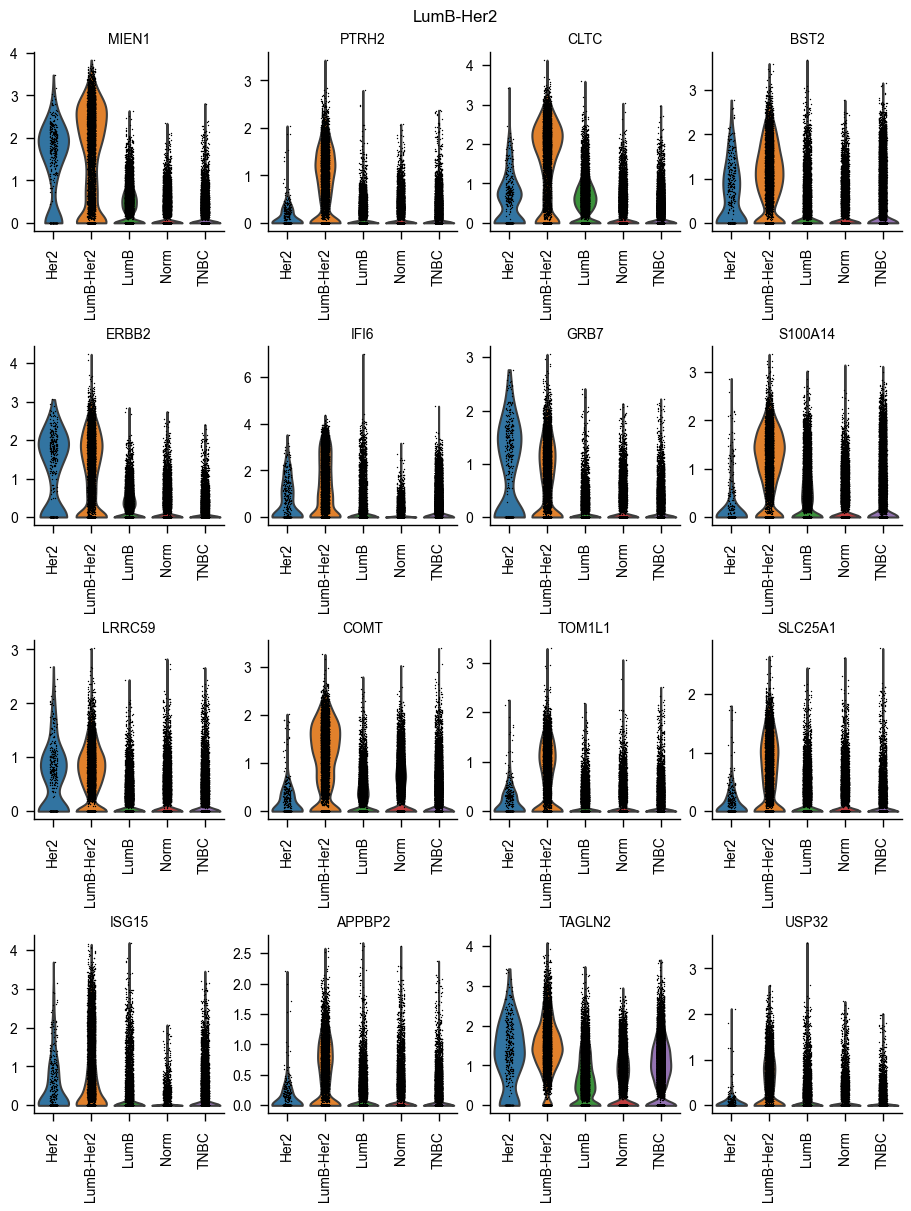

In [117]:
folder="figure-5.21"
markers = ['MIEN1', 'PTRH2', 'CLTC', 'BST2',"ERBB2", 'IFI6', 'GRB7', 'S100A14', 'LRRC59', 'COMT', 'TOM1L1', 'SLC25A1', "ISG15",'APPBP2','TAGLN2', 'USP32']
fig, ax = plt.subplots(4,4,figsize=(9,12), constrained_layout=True)
for i, m in enumerate(markers):
  col = 4
  sc.pl.violin(adata_Fepi, groupby='molecular_type',keys=m, ax=ax[int(i/col)][i%col], show=False)
  # ax[int(i/3)][i%3].legend_.remove()
  ax[int(i/col)][i%col].spines.top.set_visible(False)
  ax[int(i/col)][i%col].spines.right.set_visible(False)
  ax[int(i/col)][i%col].set_xlabel("")
  ax[int(i/col)][i%col].set_ylabel("")
  ax[int(i/col)][i%col].set_title(m, fontsize=10)
  ax[int(i/col)][i%col].set_xticklabels(["Her2", "LumB-Her2", "LumB", "Norm", "TNBC"], fontsize=10, rotation=90)
# sc.pl.umap(adata0, color='batch', ax=ax[1][3], show=False)
fig.suptitle("LumB-Her2", fontsize=12)
fig.savefig(f"{folder}/LumB-Her2.png", dpi=500)

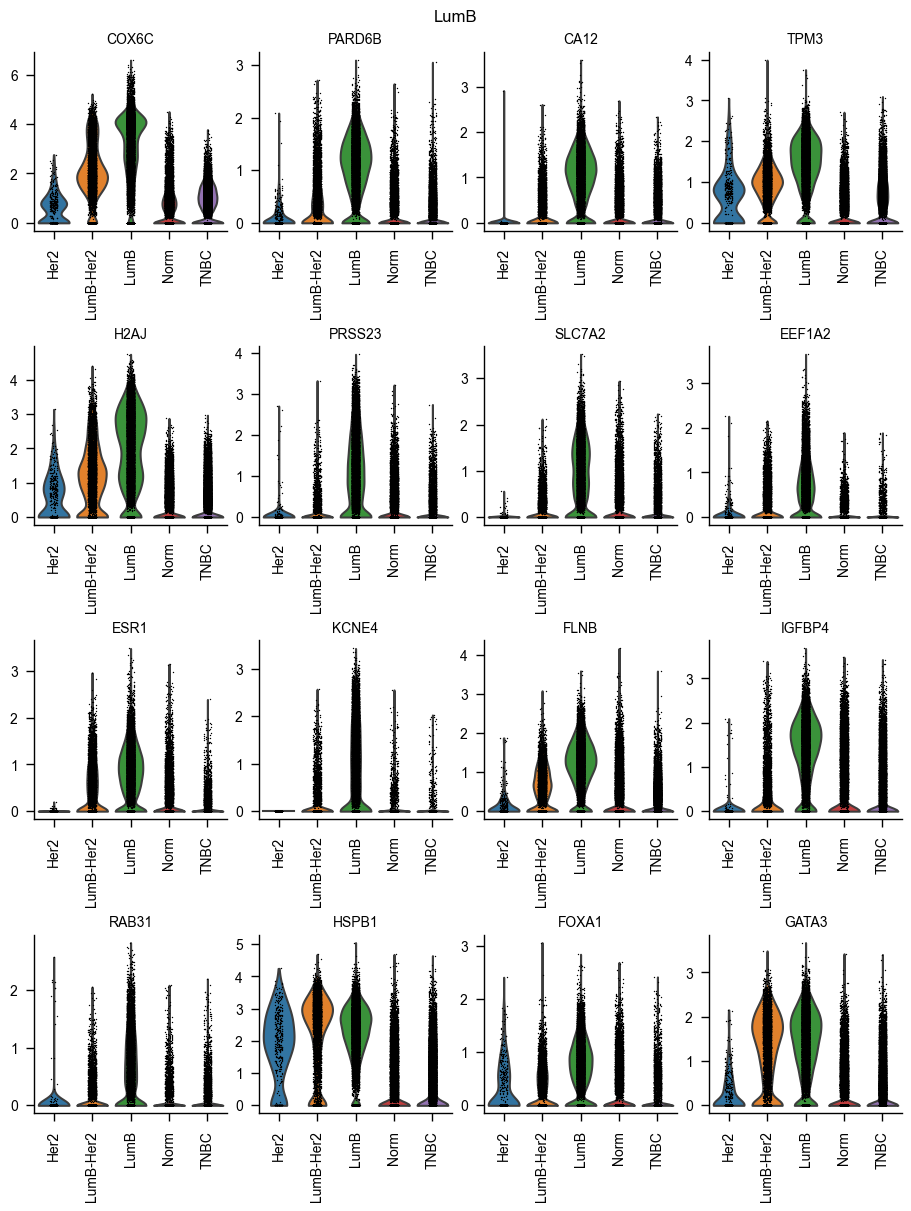

In [112]:
folder="figure-5.21"
markers = ['COX6C', 'PARD6B', 'CA12', 'TPM3',"H2AJ", 'PRSS23', 'SLC7A2', 'EEF1A2', 'ESR1', 'KCNE4', 'FLNB', 'IGFBP4', "RAB31",'HSPB1','FOXA1', 'GATA3']
fig, ax = plt.subplots(4,4,figsize=(9,12), constrained_layout=True)
for i, m in enumerate(markers):
  col = 4
  sc.pl.violin(adata_Fepi, groupby='molecular_type',keys=m, ax=ax[int(i/col)][i%col], show=False)
  # ax[int(i/3)][i%3].legend_.remove()
  ax[int(i/col)][i%col].spines.top.set_visible(False)
  ax[int(i/col)][i%col].spines.right.set_visible(False)
  ax[int(i/col)][i%col].set_xlabel("")
  ax[int(i/col)][i%col].set_ylabel("")
  ax[int(i/col)][i%col].set_title(m, fontsize=10)
  ax[int(i/col)][i%col].set_xticklabels(["Her2", "LumB-Her2", "LumB", "Norm", "TNBC"], fontsize=10, rotation=90)
# sc.pl.umap(adata0, color='batch', ax=ax[1][3], show=False)
fig.suptitle("LumB", fontsize=12)
fig.savefig(f"{folder}/LumB.png", dpi=500)

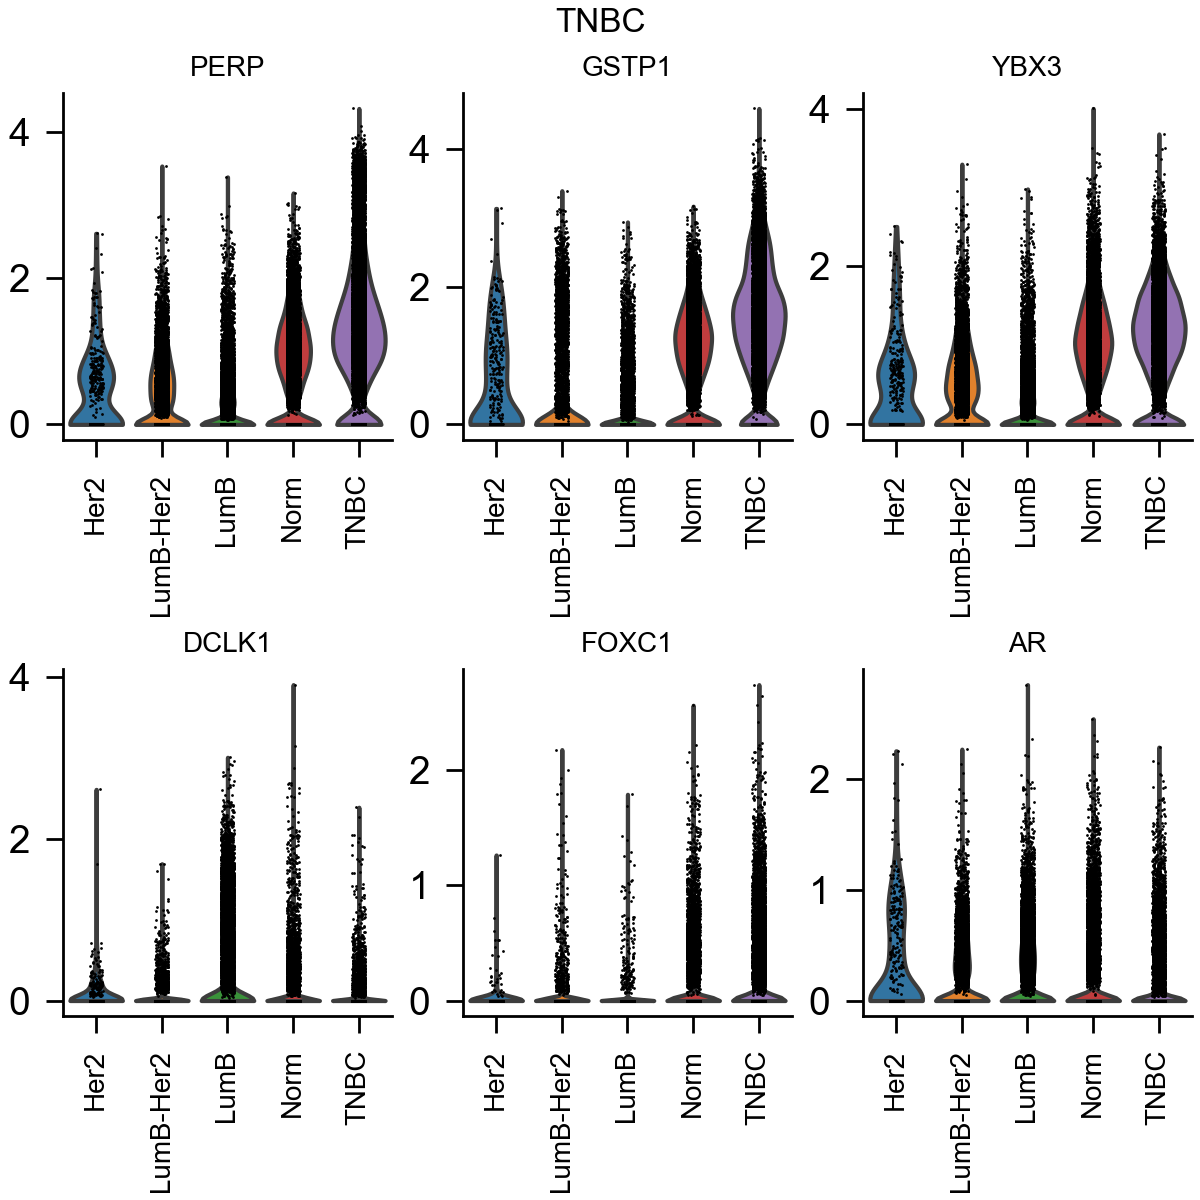

In [296]:
folder="figure-6.5"
markers = ['PERP', 'GSTP1', 'YBX3', 'DCLK1',"FOXC1", 'AR']
fig, ax = plt.subplots(2,3,figsize=(6,6), constrained_layout=True)
for i, m in enumerate(markers):
  sc.pl.violin(adata_Fepi, groupby='molecular_type',keys=m, ax=ax[int(i/3)][i%3], show=False)
  # ax[int(i/3)][i%3].legend_.remove()
  ax[int(i/3)][i%3].spines.top.set_visible(False)
  ax[int(i/3)][i%3].spines.right.set_visible(False)
  ax[int(i/3)][i%3].set_xlabel("")
  ax[int(i/3)][i%3].set_ylabel("")
  ax[int(i/3)][i%3].set_title(m, fontsize=10)
  ax[int(i/3)][i%3].set_xticklabels(["Her2", "LumB-Her2", "LumB", "Norm", "TNBC"], fontsize=10, rotation=90)
# sc.pl.umap(adata0, color='batch', ax=ax[1][3], show=False)
fig.suptitle("TNBC", fontsize=12)
fig.savefig(f"{folder}/TNBC.png", dpi=500)

0
1
2
0
1
2


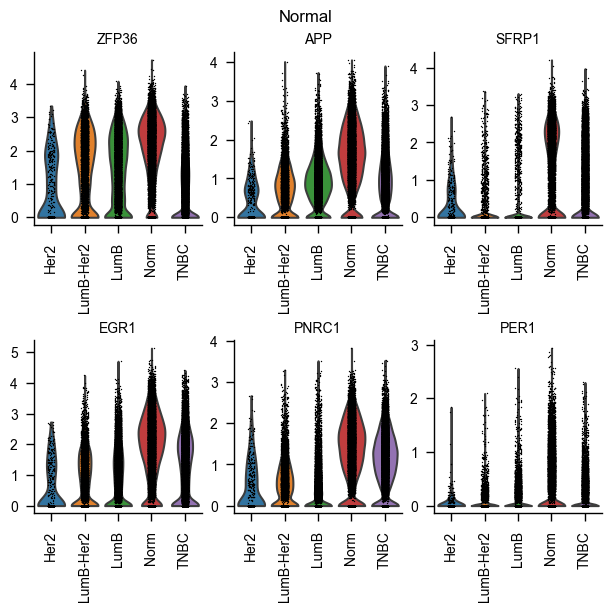

In [91]:
folder="figure-5.21"
markers = ['ZFP36', 'APP', 'SFRP1', 'EGR1', 'PNRC1', 'PER1']
fig, ax = plt.subplots(2,3,figsize=(6,6), constrained_layout=True)
for i, m in enumerate(markers):
  print(i%3)
  sc.pl.violin(adata_Fepi, groupby='molecular_type',keys=m, ax=ax[int(i/3)][i%3], show=False)
  # ax[int(i/3)][i%3].legend_.remove()
  ax[int(i/3)][i%3].spines.top.set_visible(False)
  ax[int(i/3)][i%3].spines.right.set_visible(False)
  ax[int(i/3)][i%3].set_xlabel("")
  ax[int(i/3)][i%3].set_ylabel("")
  ax[int(i/3)][i%3].set_title(m, fontsize=10)
  ax[int(i/3)][i%3].set_xticklabels(["Her2", "LumB-Her2", "LumB", "Norm", "TNBC"], fontsize=10, rotation=90)
# sc.pl.umap(adata0, color='batch', ax=ax[1][3], show=False)
fig.suptitle("Normal", fontsize=12)
fig.savefig(f"{folder}/Normal.png", dpi=500)